
**AUTO-ENCODER_Letter_Recognition**

**PUNTO 1 A** Empleando la metodología CRISP-DM desarrolle un modelo de DL basado en Aprendizaje No Supervisado Profundo.

Se toma como referencia la Metodología CRISP-DM para el desarrollo del modelo.

Para el Entendimiento y Análisis de Datos se incorpora una función para traer los datos desde las carpetas de Drive teniendo en cuenta los siguientes elementos:


*   Itera sobre archivos de la ruta.
*   Carga cada imágen en escala de grises por medio de la función cv2.imread.

*   Redimensiona imágen a tamaño 512*512.
*   Normaliza los valores de los pixeles a un rango de [0,1] al dividir por 255.


*   Agrega cada imágen que ha sido normalizada a una lista.
*   Convierte la lista en un arreglo de NumpPy.

Es importante resaltar que el tamaño de 512*512 se decidió después de múltiples iteraciones por mejorar los resultados de eliminación de ruido al dar más contexto al procesamiento realizado por el Auto-Encoder.







In [ ]:
# Se importan las librerías necesarias

import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, Reshape, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import backend as K
from google.colab import drive
from albumentations import Compose, RandomBrightnessContrast, ElasticTransform, Rotate
import matplotlib.pyplot as plt


# Enlazamos con Google Drive, en donde reposan las carpetas con la simágenes.

drive.mount('/content/drive')

# Creamos una función para cargar las imágenes

def load_images_from_drive(folder_path, img_size=(512, 512)):
    images = []
    full_path = f"/content/drive/MyDrive/{folder_path}"
    for filename in os.listdir(full_path):
        img = cv2.imread(os.path.join(full_path, filename), cv2.IMREAD_GRAYSCALE)  # Load in grayscale
        if img is not None:
            img = cv2.resize(img, img_size)
            img = img.astype('float32') / 255.0
            images.append(img)
    return np.array(images)

Mounted at /content/drive


Para la prepar los datos se realiza un aumento de los mismos por medio de la función augment_data.

Esta función realiza las siguientes acciones:


*   Crea una lista vacía para almacenar las imágenes aumentadas.

*   Establece algunas transormaciones como rotación, ajustes de brillo y contraste y deformaciones morfológicas.

*   Para cada imágen de entrenamiento se agrega a la lista, incorpora un flip horizontal, uno vertical e implementa las transformaciones definidas. Finalmente, incorpora dos imágenes con ruido gaussiano aditivo.

*   Convierte la lista en arreglo NumPy para procesamiento.
*   Valida que las comendiones sean coherentes 512 x 512 x 3 y se conviertan en 3 canales.



In [ ]:
# Generamos la función para el Data Augmentation

def augment_data(images):
    augmented_images = []
    augmentations = Compose([
        Rotate(limit=90),
        RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2),
        ElasticTransform(alpha=1, sigma=50, alpha_affine=50),
    ])
    for img in images:
        augmented_images.append(img)
        augmented_images.append(cv2.flip(img, 1))  # Horizontal flip
        augmented_images.append(cv2.flip(img, 0))  # Vertical flip
        augmented_images.append(augmentations(image=img)["image"])
        noise = np.random.normal(loc=0, scale=0.05, size=img.shape)
        augmented_images.append(np.clip(img + noise, 0, 1))
        noise = np.random.normal(loc=0, scale=0.1, size=img.shape)
        augmented_images.append(np.clip(img + noise, 0, 1))
    return np.array(augmented_images)

# Cargamos y preparamos las imágenes

train_images = load_images_from_drive("Exámen_DL_8212/train")
test_images = load_images_from_drive("Exámen_DL_8212/test")

train_images = augment_data(train_images)

# Validamos la consistencia dimensional

train_images = np.expand_dims(train_images, axis=-1)  # Añadimos dimensión de canal
train_images = np.repeat(train_images, 3, axis=-1)   # Convertimos a 3 canales
test_images = np.expand_dims(test_images, axis=-1)    # Añadimos dimensión de canal
test_images = np.repeat(test_images, 3, axis=-1)      # Convertimos a 3 canales

# Definimos capa de muestreo para el VAE

def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

Para la fase de Modelado se implementa la función uild_vae que genera un Autoencoder Variacional (VAE).

La función build_value realiza las siguientes acciones:


*   Define el encoder. Cuenta con capa convolucional con 32 filtros de 3 x 3, función de activación Relu y padding 'same'. Adicionalnete una capa de max-pooling de 2 x 2. Una capa convolucional con 128 filtros de 3x3, activación ReLu y padding 'same. Capa de max-poolong de 2x2. Capa de aplanamiento. Capa densa con 256 neuronas y función de Activación ReLU. Capa densa para estimar varianza de distribución latente y Capa Lambda que muestrea espacio latente con remuestreo.

*   Define el Decoder. En este paso se toman las muestras del espacio latente como entrada. Se pasan las muestras por medio de una capa densa con 64 x 64 x 128 neuronas y activación Relu. Redimensiona la salida a densa. Implementa un unsampling de 2 x 2 y convoluciones para la reconstrucción de la imágen de salida. Capa convlucional final con 3 filtros de 3x3, activación sigmoidea y padding 'same' para generar imágen de salida.

*   Se conbina el encoder y el decoder para formar el VAE.


*   Se define función de pérdida, en este caso una combinación entre Mean Squared Error y la perdida de regularización KL.

In [ ]:

# Creamos función crear modelo

def build_vae(input_shape=(512, 512, 3), latent_dim=128):
    # Encoder
    inputs = Input(shape=input_shape, name='encoder_input')
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_log_var = Dense(latent_dim, name='z_log_var')(x)

    z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

    encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
    encoder.summary()

    # Encoder

def build_vae(input_shape=(512, 512, 3), latent_dim=128):
    # Encoder
    inputs = Input(shape=input_shape, name='encoder_input')
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_log_var = Dense(latent_dim, name='z_log_var')(x)

    z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

    encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
    encoder.summary()

    # Decoder

    latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
    x = Dense(64 * 64 * 128, activation='relu')(latent_inputs)
    x = Reshape((64, 64, 128))(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    decoder = Model(latent_inputs, x, name='decoder')
    decoder.summary()

    # Definimos Modelo VAE

    outputs = decoder(encoder(inputs)[2])
    vae = Model(inputs, outputs, name='vae')

    # Definimos Pérdida para VAE

    reconstruction_loss = MeanSquaredError()(inputs, outputs)
    reconstruction_loss *= input_shape[0] * input_shape[1]
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    vae_loss = K.mean(reconstruction_loss + kl_loss)
    vae.add_loss(vae_loss)
    return vae

# Construimos y compilamos el modelo

vae = build_vae()
vae.compile(optimizer='adam')

# Porogramamos la tasa de aprendizaje

lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

# Entrenamos el Modelo

vae.fit(train_images, epochs=50, batch_size=8, shuffle=True, validation_split=0.1, callbacks=[lr_reducer])

# Guardamos el modelo

vae.save('/content/drive/MyDrive/vae_model.keras')

# Creamos función para recuperar texto

def recover_text(vae, images):
    recovered_images = vae.predict(images)
    return recovered_images



Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 512, 512, 32)         896       ['encoder_input[0][0]']       
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 256, 256, 32)         0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 64)         18496     ['max_pooling2d[0][0]'] 

Para la Evaluación, se compila el modelo con base en optimizador 'Adam'.

Se define un ReduceLROnPlateau que s eutiliza para ajustar la tasa de aprendizaje en aquellos casos en los que la pérdida durante la validación no mejora.

Se entrena el modelo VAE en 50 épocas con un batch de 8 y utilizando datos de entrenamiento aumentados.



3/3 [==============================] - 3s 42ms/step


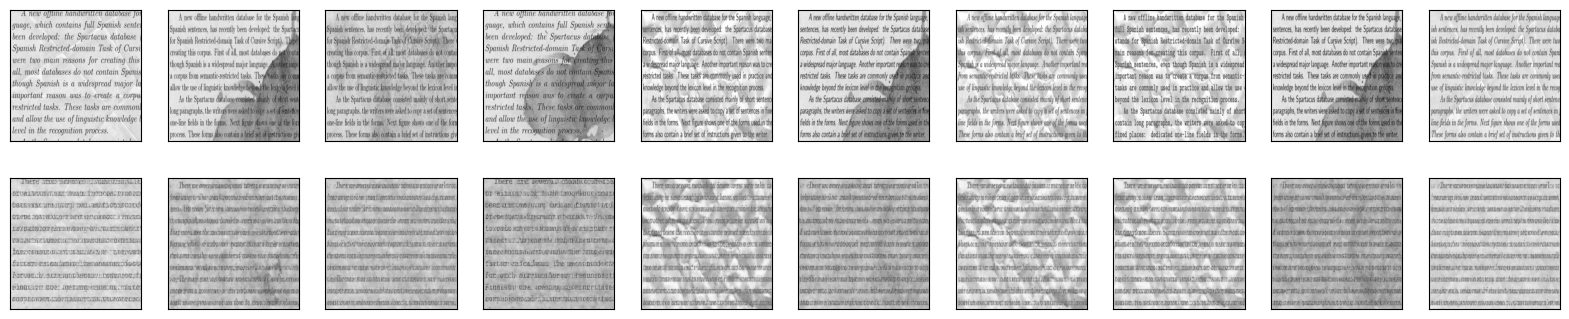

In [ ]:
# Aplicamos modelo estimado a Test

recovered_images = recover_text(vae, test_images)

# Visualizamos Resultados

plt.figure(figsize=(20, 4))
for i in range(10):

    # Original

    ax = plt.subplot(2, 10, i + 1)
    plt.imshow(test_images[i].reshape(512, 512, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Recuperado

    ax = plt.subplot(2, 10, i + 11)
    plt.imshow(recovered_images[i].reshape(512, 512, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Los resultados muestran dificulltades para el Auto Encoderen la remoción de ruido de fondo. En algunas imágenes, el AutoEncoder difumina alguna tonalidad mientras que en lo que parecen ser superficies rusosas parece estar reforzando el efecto. Una de las posibles causas es el pequeño tamaño del conjunto de train, lo cual dificulta la extracción de características latentes en modelos no supervisados. Esto se refleja también en el Loss de MSE, el cual nunca alcanza en todo el entrenamiento una cifra decimal.

In [ ]:
%reset -f

**PUNTO 1 B** Empleando la metodología CRISP-DM desarrolle un modelo de DL d diferente naturaleza al del ítem A.

Para el Entendimiento de Datos, el proceso carga los tres conjuntos de imágenes provistos para el desarrollo del Parcial: train, train_clean y test.

Se genera una función similar a la anterior en cuanto a la carga de dichas imágenes para la impementación de los modelos.

En particular, realiza los siguientes procedimientos:



*   Itera sobre las imágenes en las rutas especificadas.

*   Carga las imágenes en escala de grises. Esto apra facilitar el procesamiento.

*   Redimensiona cada imágen al tamaño 512x512.

*   Normaliza pixeles al rango [0,1]
*   Convierte imágenes a 3 canales.


*   Agrega cad aimágen normalizada a una lista.


*   Convierte la lista a un arreglo NumPy.



In [ ]:
# Instalamos e importamos librerías necesarias

!pip install tensorflow-addons

import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from google.colab import drive
from albumentations import Compose, RandomBrightnessContrast, ElasticTransform, Rotate, Blur
from tensorflow.keras.losses import MeanSquaredError
from tensorflow_addons.optimizers import AdamW

# Cargamos el Drive

drive.mount('/content/drive', force_remount=True)

# Generamos la función para tomar las imágenes desde Drive

def load_images_from_drive(folder_path, img_size=(512, 512)):
    images = []
    full_path = f"/content/drive/MyDrive/{folder_path}"
    for filename in sorted(os.listdir(full_path)):
        img = cv2.imread(os.path.join(full_path, filename), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, img_size)
            img = img.astype('float32') / 255.0
            img = np.stack((img, img, img), axis=-1)
            images.append(img)
    return np.array(images)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 16.4 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Mounted at /content/drive


Para la Preparación de Datos se implementan diversas ttransformaciones en los datos de entrenamiento.

En particular, sse implementan las siguientes acciones:


*   Se valida que train y train_cleaned tengan misma cantidad de imágenes para poder etiquetar y componer el ejercicio supervisado.

*   Se aumentan imágenes ruidosas por medio de rotación de hasta 90 grados, cambios aleatorios de brillo y contraste, deformaciones morfológicas y desenfoque gaussiano aleatorio.




In [ ]:
# Generamos Función para Aumentar Datos

def augment_data(images, augmentations):
    augmented_images = []
    for img in images:
        augmented_images.append(img)
        augmented_images.append(cv2.flip(img, 1))
        augmented_images.append(cv2.flip(img, 0))
        augmented_images.append(augmentations(image=img)["image"])
        # Añadimos Ruido Gausiano
        noise = np.random.normal(loc=0, scale=0.05, size=img.shape)
        augmented_images.append(np.clip(img + noise, 0, 1))
        noise = np.random.normal(loc=0, scale=0.1, size=img.shape)
        augmented_images.append(np.clip(img + noise, 0, 1))
    return np.array(augmented_images)

# Cargamos y preparamos imágenes

train_images_noisy = load_images_from_drive("Exámen_DL_8212/train", img_size=(512, 512))
train_images_clean = load_images_from_drive("Exámen_DL_8212/train_cleaned", img_size=(512, 512))
test_images = load_images_from_drive("Exámen_DL_8212/test", img_size=(512, 512))

# Validamos Consistencia d Dimensiones

min_samples = min(len(train_images_noisy), len(train_images_clean))
train_images_noisy = train_images_noisy[:min_samples]
train_images_clean = train_images_clean[:min_samples]

# Aumentamos las imágenes con ruido

augmentations = Compose([
    Rotate(limit=90),
    RandomBrightnessContrast(brightness_limit=0.4, contrast_limit=0.4),
    ElasticTransform(alpha=3, sigma=50, alpha_affine=50),
    Blur(blur_limit=4),
])
train_images_noisy = augment_data(train_images_noisy, augmentations)


# Cruzamos imágenes limpias con ruidosas para facilitar ejercicio

repeat_factor = len(train_images_noisy) // len(train_images_clean)
train_images_clean = np.repeat(train_images_clean, repeat_factor, axis=0)
if len(train_images_noisy) > len(train_images_clean):
    train_images_clean = np.concatenate([train_images_clean, train_images_clean[:len(train_images_noisy) - len(train_images_clean)]], axis=0)


Para el Modelado se define una función unet_model, el cual genera un autoencoder U-Net con skip-connections y reducción de  número de filtros.

La arquitectura considerada está compuesta para el Encoder de la siguiente forma:


*   Capa convolucional con 64 filstros de 3 x 3, activación Relu y padding 'same'.
*   Capa de normalización por lotes.

*   Capa de dropout con tasa de 0.5.

*   Caoa de max-pooling de 2x2.
*   Repetición de acciones anteriores con 32 y 16 filtros.

Para el 'Bottleneck' se implementa una capa convolucional de 8 filtros de 3x3, activación ReLU y padding 'same' seguida de una capa de normalización por lotes.

En el caso del Decoder, se cuenta con una capa de upsamplir de 2 x 2. Adicionalmente, se reliza lo siguiente:

*   Concatenación con características correspondientes del encoder.

*   Capa convolucional con 16 filtros de 3 x 3, fnción de activación ReLU y padding 'same' seguida de capa de normalización por lotes.

*   Se repiten pasos anteriores con 32 y 64 filtros.

*   Se tiene una capa convolucional final con 3 filtros de 3 x 3, activación sigmoidea y padding 'same' para generar la imágen de salida.

Sumado a lo anterior se compila el modelo con optimizar AdamW (con Decaimiento), una tasa de aprendizaje inicial y na regularización particular con función de périda Mean Squared Error.


In [ ]:
# Definimos modelo con Transfer Learning y Skip Connections

def unet_model(input_size=(512, 512, 3)):
    inputs = Input(input_size)

    # Encoder

    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Dropout(0.5)(c1)
    p1 = MaxPooling2D((2, 2), padding='same')(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Dropout(0.5)(c2)
    p2 = MaxPooling2D((2, 2), padding='same')(c2)

    c3 = Conv2D(16, (3, 3), activation='relu', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Dropout(0.5)(c3)
    p3 = MaxPooling2D((2, 2), padding='same')(c3)

    # Enlace

    c4 = Conv2D(8, (3, 3), activation='relu', padding='same')(p3)
    c4 = BatchNormalization()(c4)

    # Decoder

    u1 = UpSampling2D((2, 2))(c4)
    concat1 = Concatenate()([u1, c3])
    c5 = Conv2D(16, (3, 3), activation='relu', padding='same')(concat1)
    c5 = BatchNormalization()(c5)

    u2 = UpSampling2D((2, 2))(c5)
    concat2 = Concatenate()([u2, c2])
    c6 = Conv2D(32, (3, 3), activation='relu', padding='same')(concat2)
    c6 = BatchNormalization()(c6)

    u3 = UpSampling2D((2, 2))(c6)
    concat3 = Concatenate()([u3, c1])
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(concat3)
    c7 = BatchNormalization()(c7)

    outputs = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(c7)

    model = Model(inputs, outputs)
    return model

# Creamos Modelo

autoencoder = unet_model(input_size=(512, 512, 3))

# Ajustamos función de pérdida para mantener detalles

mse = MeanSquaredError()
autoencoder.compile(optimizer=AdamW(learning_rate=1e-4, weight_decay=1e-5), loss=mse)

# Programamos Tasa de Aprendizaje

lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)


# Realizamos Fine-Tunning s

autoencoder.fit(train_images_noisy, train_images_clean, epochs=100, batch_size=8, shuffle=True, validation_split=0.2, callbacks=[lr_reducer])

# Guardamos Modelo

autoencoder.save('/content/drive/MyDrive/autoencoder_unet_finetuned.h5')


Epoch 1/100
87/87 [==============================] - 37s 211ms/step - loss: 0.1859 - val_loss: 0.0992 - lr: 1.0000e-04
Epoch 2/100
87/87 [==============================] - 9s 105ms/step - loss: 0.1148 - val_loss: 0.0618 - lr: 1.0000e-04
Epoch 3/100
87/87 [==============================] - 9s 106ms/step - loss: 0.0922 - val_loss: 0.0517 - lr: 1.0000e-04
Epoch 4/100
87/87 [==============================] - 9s 105ms/step - loss: 0.0800 - val_loss: 0.1170 - lr: 1.0000e-04
Epoch 5/100
87/87 [==============================] - 9s 105ms/step - loss: 0.0717 - val_loss: 0.1587 - lr: 1.0000e-04
Epoch 6/100
87/87 [==============================] - 9s 105ms/step - loss: 0.0654 - val_loss: 0.0709 - lr: 1.0000e-04
Epoch 7/100
87/87 [==============================] - 9s 105ms/step - loss: 0.0620 - val_loss: 0.0688 - lr: 2.0000e-05
Epoch 8/100
87/87 [==============================] - 9s 105ms/step - loss: 0.0610 - val_loss: 0.0652 - lr: 2.0000e-05
Epoch 9/100
87/87 [==============================] - 9s

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Para la evaluación se define un ReduceLROnPlateau que permite ajustar la tasa de aprendizaje si la validación no mejora. Se tiene un número de épocas sin mejora como límite antes de reducir tasa de aprendizaje de 3.

De esta forma, durante el entrenamiento el modelo está aprendiendo a mapear las imágenes con ruido respecto a la simágenes limpias, lo cual le facilita la tarea de eliminación de ruido y los artefactos en las imágenes.

3/3 [==============================] - 3s 52ms/step


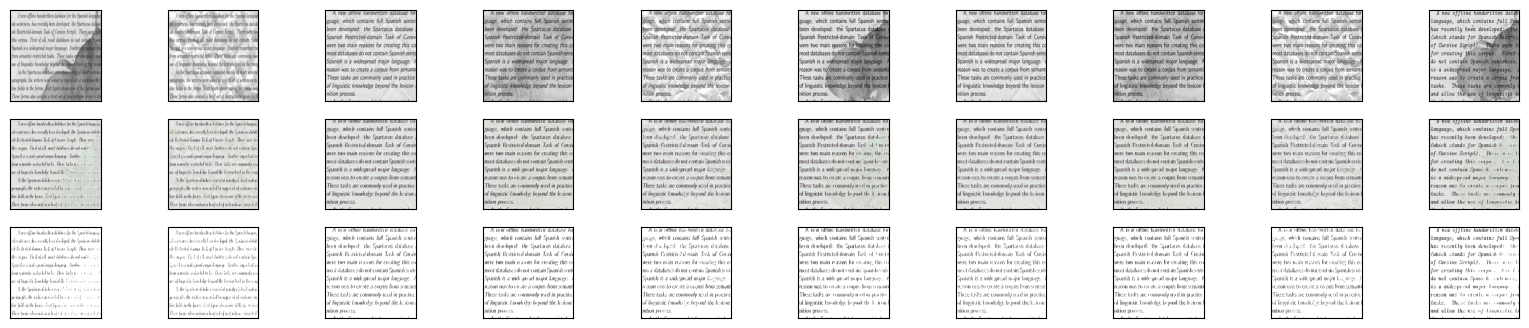

In [ ]:

# Generamos función para quitar ruido a imágenes

def denoise_images(autoencoder, images):
    denoised_images = autoencoder.predict(images)
    return denoised_images

# Implementamos post-procesamiento para mejorar calidad de la imágen

def postprocess_images(images):
    processed_images = []
    for img in images:
        img = (img * 255).astype(np.uint8)  # Convert image to 8-bit
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        binary = cv2.bitwise_not(binary)
        processed_img = cv2.cvtColor(binary, cv2.COLOR_GRAY2BGR)
        processed_img = cv2.bitwise_not(processed_img)  # Invert to get black text on white background
        processed_images.append(processed_img)
    return np.array(processed_images)

# Aplicamos función de eliminación d eruido

denoised_images = denoise_images(autoencoder, test_images)

# Aplicamos Post Procesamiento

postprocessed_images = postprocess_images(denoised_images)

# Visualizamos resultados

import matplotlib.pyplot as plt

plt.figure(figsize=(20, 4))
for i in range(10):

    # Mostramos original
    ax = plt.subplot(3, 10, i + 1)
    plt.imshow(test_images[i].reshape(512, 512, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Mostramos con Transformación

    ax = plt.subplot(3, 10, i + 11)
    plt.imshow(denoised_images[i].reshape(512, 512, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Mostramos con Post-Procesamiento

    ax = plt.subplot(3, 10, i + 21)
    plt.imshow(postprocessed_images[i].reshape(512, 512, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

De acuerdo con lo anterior, los resultados muestran queel uso de imágenes limpias para utilizarlas como etiquetas facilitan el entrenamiento y la remoción de efectos de fondo. Las imágenes anteriores muestran que sin importar el tipo de ruido presente en la muestra, la apoximación supervisada con Transfer Learning a través de una U-NET permite capturar con mayor facilidad patrones latentes y utilizarlos para hacer ingeniería de imágenes. Dichos resultados también son evidentes en el MSE, el cual en todas las iteracciones está al rededor de 0,05.

Cabe resaltar que la métrica MSE resulta de gran ayuda en el contexto actual, teniendo en cuenta su medida de diferencia de pixeles entre la imágen original y la imágen depurada, en el cual un valor menor, como en el caso supervisado, es preferible a uno mayor.

**BONUS** Empleando la metodología CRISP-DM desarrolle un modelo de DL d diferente naturaleza al del ítem A.

Con base en los resultados anteriores, se realiza una optimización de Hiperparámetros considerando las limitaciones computacionales asociadas a mayores complejidades en los modelos.

En el presente caso, se implementa una Grilla con factores de 'Dropout Rate' y 'Learning Rate'. El rango para la primera es desde 0,3 a 0,7 con un paso de 0,1. El segundo tiene opciones de 1e-2, 1e-3 y 1e-4.

Las combinaciones de hiperparámetros se combinan sobre la arquitectura de U-Net por medio de un RandomSearch de tal manera que se minimice la función de costo.

In [ ]:
%reset -f

In [ ]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.9 MB/s eta 0:00:00


Trial 10 Complete [00h 01m 45s]
val_loss: 0.03162359073758125

Best val_loss So Far: 0.03162359073758125
Total elapsed time: 00h 17m 27s


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 0s 81ms/step


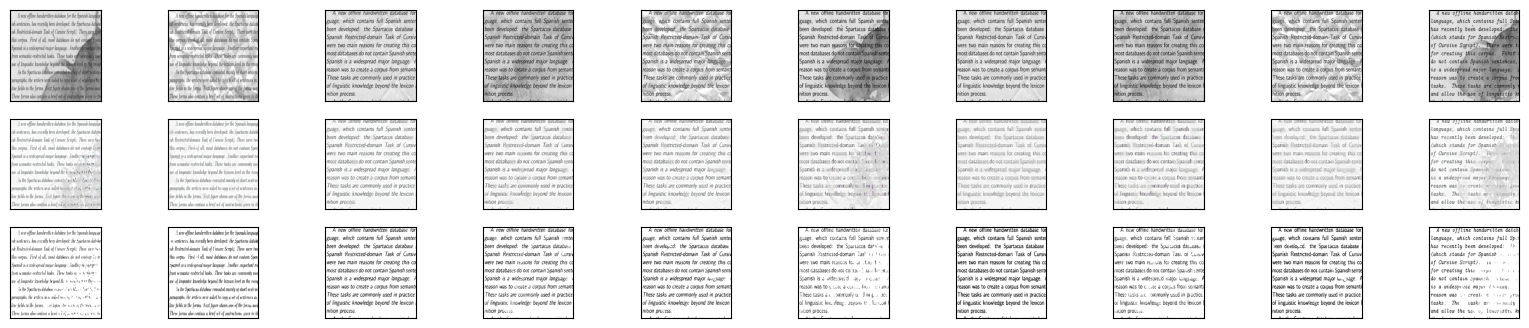

In [ ]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dropout, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import ReduceLROnPlateau
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from albumentations import Compose, Rotate, RandomBrightnessContrast, ElasticTransform, Blur
import matplotlib.pyplot as plt
from google.colab import drive

# Cargamos el Drive

drive.mount('/content/drive', force_remount=True)

# Generamos la función para tomar las imágenes desde Drive

def load_images_from_drive(folder_path, img_size=(512, 512)):
    images = []
    full_path = f"/content/drive/MyDrive/{folder_path}"
    for filename in sorted(os.listdir(full_path)):
        img = cv2.imread(os.path.join(full_path, filename), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, img_size)
            img = img.astype('float32') / 255.0
            img = np.stack((img, img, img), axis=-1)
            images.append(img)
    return np.array(images)


# Función para aumentar datos

def augment_data(images, augmentations):
    augmented_images = []
    for img in images:
        augmented_images.append(img)
        augmented_images.append(cv2.flip(img, 1))
        augmented_images.append(cv2.flip(img, 0))
        augmented_images.append(augmentations(image=img)["image"])
        noise = np.random.normal(loc=0, scale=0.05, size=img.shape)
        augmented_images.append(np.clip(img + noise, 0, 1))
        noise = np.random.normal(loc=0, scale=0.1, size=img.shape)
        augmented_images.append(np.clip(img + noise, 0, 1))
    return np.array(augmented_images)

# Cargamos imágenes

train_images_noisy = load_images_from_drive("Exámen_DL_8212/train", img_size=(512, 512))
train_images_clean = load_images_from_drive("Exámen_DL_8212/train_cleaned", img_size=(512, 512))
test_images = load_images_from_drive("Exámen_DL_8212/test", img_size=(512, 512))

# Validamos consistencia de dimensiones

min_samples = min(len(train_images_noisy), len(train_images_clean))
train_images_noisy = train_images_noisy[:min_samples]
train_images_clean = train_images_clean[:min_samples]

# Aumentamos imágenes

augmentations = Compose([
    Rotate(limit=90),
    RandomBrightnessContrast(brightness_limit=0.4, contrast_limit=0.4),
    ElasticTransform(alpha=3, sigma=50, alpha_affine=50),
    Blur(blur_limit=4),
])
train_images_noisy = augment_data(train_images_noisy, augmentations)

# Validamos cruce entre imágenes con ruido y limpias

repeat_factor = len(train_images_noisy) // len(train_images_clean)
train_images_clean = np.repeat(train_images_clean, repeat_factor, axis=0)
if len(train_images_noisy) > len(train_images_clean):
    train_images_clean = np.concatenate([train_images_clean, train_images_clean[:len(train_images_noisy) - len(train_images_clean)]], axis=0)

# Definimos Modelo U-Net

def unet_model(hp):
    inputs = Input((512, 512, 3))
    dropout_rate = hp.Float('dropout_rate', 0.3, 0.7, step=0.1)

    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Dropout(dropout_rate)(c1)
    p1 = MaxPooling2D((2, 2), padding='same')(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Dropout(dropout_rate)(c2)
    p2 = MaxPooling2D((2, 2), padding='same')(c2)

    c3 = Conv2D(16, (3, 3), activation='relu', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Dropout(dropout_rate)(c3)
    p3 = MaxPooling2D((2, 2), padding='same')(c3)

    c4 = Conv2D(8, (3, 3), activation='relu', padding='same')(p3)
    c4 = BatchNormalization()(c4)

    u1 = UpSampling2D((2, 2))(c4)
    concat1 = Concatenate()([u1, c3])
    c5 = Conv2D(16, (3, 3), activation='relu', padding='same')(concat1)
    c5 = BatchNormalization()(c5)

    u2 = UpSampling2D((2, 2))(c5)
    concat2 = Concatenate()([u2, c2])
    c6 = Conv2D(32, (3, 3), activation='relu', padding='same')(concat2)
    c6 = BatchNormalization()(c6)

    u3 = UpSampling2D((2, 2))(c6)
    concat3 = Concatenate()([u3, c1])
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(concat3)
    c7 = BatchNormalization()(c7)

    outputs = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(c7)

    model = Model(inputs, outputs)
    return model

# Definitmos la optimización con Keras Tuner

def build_model(hp):
    model = unet_model(hp)
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss=MeanSquaredError())
    return model

tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='hyperparam_tuning',
    project_name='unet_optimization'
)

tuner.search_space_summary()

# Entrenamos el modelo utilizando grid search

tuner.search(train_images_noisy, train_images_clean, epochs=10, batch_size=8, validation_split=0.2)

# Obtenemos Mejor Modelo

best_model = tuner.get_best_models(num_models=1)[0]
best_model.save('/content/drive/MyDrive/autoencoder_unet_best.h5')

# Generamos función par alimpiar imágenes

def denoise_images(autoencoder, images):
    denoised_images = autoencoder.predict(images)
    return denoised_images

# Implementamos postprocesamiento para mejorar calidad de imágenes

def postprocess_images(images):
    processed_images = []
    for img in images:
        img = (img * 255).astype(np.uint8)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        binary = cv2.bitwise_not(binary)
        processed_img = cv2.cvtColor(binary, cv2.COLOR_GRAY2BGR)
        processed_img = cv2.bitwise_not(processed_img)
        processed_images.append(processed_img)
    return np.array(processed_images)

# Aplicamos función para eliminar ruido

denoised_images = denoise_images(best_model, test_images)

# Aplicamos Postprocesamiento

postprocessed_images = postprocess_images(denoised_images)

# Visualizamos Resultados

plt.figure(figsize=(20, 4))
for i in range(10):
    ax = plt.subplot(3, 10, i + 1)
    plt.imshow(test_images[i].reshape(512, 512, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(3, 10, i + 11)
    plt.imshow(denoised_images[i].reshape(512, 512, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(3, 10, i + 21)
    plt.imshow(postprocessed_images[i].reshape(512, 512, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


La Optimización de Hiperparámetros muestra un menor MSE con respecto a ambos modelos previos. Adicionalmente y de manera visual, se mejora la limpieza de ruido y la reconstrucción de texto. Una mayor profundidad en el modelo (inviable por el recurso computacional actual) y técnicas más avanzadas de pre y postprocesamiento, pueden contribuir a mejorar los resultados obtenidos.